# Training a Classifier

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/borchero/pyblaze/blob/master/docs/guides/classifier.ipynb)
[![Download Jupyter Notebbok](https://img.shields.io/badge/Github-Download-brightgreen)](https://github.com/borchero/pyblaze/blob/master/docs/guides/classifier.ipynb)

Training a classifier on images is one of the most prominent examples showcasing what a library can do. Inspired by PyTorch’s tutorials, we want to train a convolutional neural network on the CIFAR10 dataset using the features of PyBlaze.

At first, we import all libraries that we’re going to use throughout this example:

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import pyblaze.nn as xnn
import pyblaze.nn.functional as X
import matplotlib.pyplot as plt

## Loading the Data

At the beginning, we load our data conveniently using torchvision. PyBlaze does not come into play yet.

In [2]:
train_val_dataset = torchvision.datasets.CIFAR10(
    root="~/Downloads/", train=True, download=True, transform=transforms.ToTensor()
)
test_dataset = torchvision.datasets.CIFAR10(
    root="~/Downloads/", train=False, download=True, transform=transforms.ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


### Initializing Data Loaders

First, we set aside 20% of all training data for validation. Usually, you would need to compute the sizes of the resulting subsets and then split the dataset randomly. However, using PyBlaze, you can do this more conveniently.

By simply importing pyblaze.nn, datasets receive an additional function random_split. This accepts arbitrarily many floating point numbers indicating the fraction of the dataset to be randomly sampled into subsets. Note that these numbers need to add to 1.

In [3]:
train_dataset, val_dataset = train_val_dataset.random_split(0.8, 0.2)

Finally, we can initialize the data loaders. Normally, you would initialize a data loader and pass the dataset to the initializer. However, this always feels odd. Hence, as soon as you import pyblaze.nn, we extend PyTorch’s native dataset with a loader method. The method creates a data loader while its parameters are the same as for PyTorch’s data loader initializer.

In [4]:
train_loader = train_dataset.loader(batch_size=256, num_workers=4, shuffle=True)
val_loader = val_dataset.loader(batch_size=2048)
test_loader = test_dataset.loader(batch_size=2048)

Note that we set the batch size for validation and testing significantly higher than for training: as we are running the model in eval mode, no gradients need to be stored and much less memory is required.

## Defining the Model

As a model, we define a common convolutional neural network. Most importantly, defining a model for PyBlaze is no different than defining a model natively in PyTorch. However, PyBlaze provides additional functionality to make it easier working with models.

One feature that we are using here is the Estimator mixin. Conforming to this class adds three methods to the model: `fit`, `evaluate` and `predict`. While you may implement these methods yourself, the default implementation delegates the functionality of these methods to an engine. The engine class is the heart of PyBlaze, driving the training of models. You may define the engine class to use using the `__engine__` class variable.

In [5]:
class Model(xnn.Estimator, nn.Module):

    __engine__ = xnn.SupervisedEngine

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 400)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Note that using the `Estimator` mixin is no requirement. You may also initialize the engine explicitly while passing the model and then call `train` or related methods on the engine. This has the same effect. However, defining a default engine to use is useful in cases where the model is used in many different places in a program and always requires the same engine.

Likewise, it is a useful feature for developing libraries: when defining a model, an engine can be used to decouple training code from the model definition. Setting a default engine can then bind the training code to the model and hide the complexity of initializing an extra engine from the end user.

Initializing a model is as simple as for pure PyTorch modules. In case the model has some configuration parameters and you want to save the model’s architecture along with its weights to a file, consider using the `xnn.Configurable` mixin (see the class documentation).

In [6]:
model = Model()

## Training the Model

Model training and evaluation is the core feature of PyBlaze. The following code trains the model as follows:

* By calling fit on the model itself, we use the model’s default engine and call its train method with the provided parameters.
* We train with the data from train_loader and evaluate the performance after every epoch with data from val_loader.
* We train for 20 epochs (max) and use early stopping with a patience of 3 epochs. By default, we watch the validation loss when using early stopping. This can, however, be changed in a simple way.
* We use Adam with its default parameters as optimizer and minimize the cross entropy loss.
* We log the progress of each batch to the command line.
* We compute the accuracy of the predictions of the validation data after every epoch.
* The result of this call is a history object which aggregates information about the training. This includes train losses after every batch as well as epoch. Further, it includes validation losses and validation metrics after every epoch.

In [7]:
optimizer = optim.Adam(model.parameters())
history = model.fit(
    train_loader,
    val_data=val_loader,
    epochs=50,
    optimizer=optimizer,
    loss=nn.CrossEntropyLoss(),
    callbacks=[
        xnn.BatchProgressLogger(),
        xnn.EarlyStopping(patience=3)
    ],
    metrics={
        'accuracy': X.accuracy
    }
)

Epoch 1/50:
 [Elapsed 0:00:03] train_loss: 2.02567, val_accuracy: 0.30970, val_loss: 1.84723
Epoch 2/50:
 [Elapsed 0:00:03] train_loss: 1.77802, val_accuracy: 0.37650, val_loss: 1.69289
Epoch 3/50:
 [Elapsed 0:00:03] train_loss: 1.65098, val_accuracy: 0.41220, val_loss: 1.59843
Epoch 4/50:
 [Elapsed 0:00:03] train_loss: 1.56401, val_accuracy: 0.44260, val_loss: 1.51837
Epoch 5/50:
 [Elapsed 0:00:03] train_loss: 1.50176, val_accuracy: 0.46560, val_loss: 1.46846
Epoch 6/50:
 [Elapsed 0:00:03] train_loss: 1.44907, val_accuracy: 0.46450, val_loss: 1.48218
Epoch 7/50:
 [Elapsed 0:00:03] train_loss: 1.41274, val_accuracy: 0.48680, val_loss: 1.41563
Epoch 8/50:
 [Elapsed 0:00:03] train_loss: 1.37364, val_accuracy: 0.50790, val_loss: 1.35862
Epoch 9/50:
 [Elapsed 0:00:03] train_loss: 1.33761, val_accuracy: 0.52610, val_loss: 1.32375
Epoch 10/50:
 [Elapsed 0:00:03] train_loss: 1.30594, val_accuracy: 0.54160, val_loss: 1.28599
Epoch 11/50:
 [Elapsed 0:00:03] train_loss: 1.27092, val_accuracy: 0.

### Plotting the Losses

With the information from the history object, we can plot the progress of our training. The history object always provides `micro_train_loss` summarizing the train losses after each batch as well as `train_loss` as the train losses after each epoch. Depending on additional parameters passed to the fit function, additional keys are available.

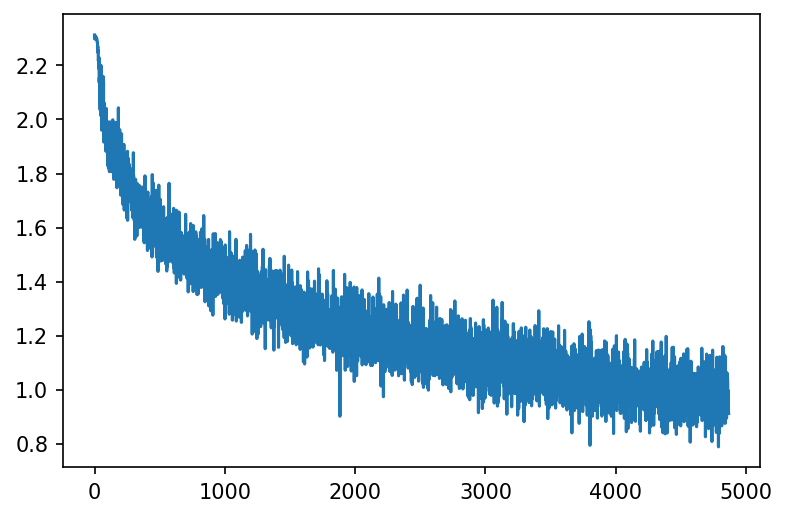

In [8]:
all_losses = history.micro_train_loss
plt.figure(dpi=150)
plt.plot(range(len(all_losses)), all_losses)
plt.show()

In our case, we used validation and therefore there exists a val_loss property on the history object. Theoretically, we would also be able to plot val_accuracy as all metrics are recorded in the history object as well.

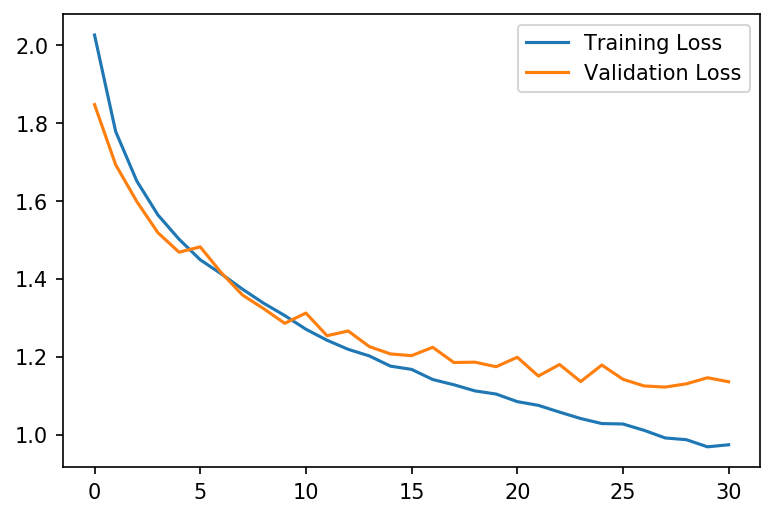

In [9]:
plt.figure(dpi=150)
plt.plot(range(len(history)), history.train_loss, label='Training Loss')
plt.plot(range(len(history)), history.val_loss, label='Validation Loss')
plt.legend()
plt.show()

As we can see, the losses are starting to diverge and the generalization gap becomes larger. We can see that the early stopping procedure did a good job stopping training prematurely.

### Evaluating the Model

Lastly, we want to evaluate the performance of our model. For this, we use our test data and call `evaluate` on the model. We are interested only in a single metric, the accuracy.

The returned value is an `Evaluation` object which provides as attributes the metrics that were recorded. In our case, the only attribute is `accuracy`.

In [10]:
evaluation = model.evaluate(
    test_loader,
    callbacks=[
        xnn.PredictionProgressLogger()
    ],
    metrics={
        'accuracy': X.accuracy
    }
)

 [Elapsed 0:00:01] =============] (100.0%) ETA 0:00:00 [Elapsed 0:00:01]


In [11]:
print(f"Our model achieves an accuracy of {evaluation.accuracy:.2%}.")

Our model achieves an accuracy of 60.46%.


## Using GPUs

As PyBlaze is a framework dedicated for large-scale machine learning, it has first-class support for GPUs. In fact, in order to run training and evaluation on a GPU, **you do not have to do anything**. In fact, if you had a GPU at your disposal when running this tutorial, you already used it. Generally, PyBlaze will use all available GPUs automatically, speeding up training as much as possible.

If you have multiple GPUs and want to use a specific one, just pass `gpu=<ID>` to any of the functions above. Likewise, you can select a subset of GPUs by providing `gpu=[<ID1>, <ID2>, …]` or no GPU at all by using `gpu=False`.

A special case is `gpu=True` which chooses a single GPU: the one with the most amount of free memory.